# Kenya Antenna Position Calibration

Author: Tim Molteno. tim@elec.ac.nz.

The antennas are laid out on five spiral arms.  This notebook will use measurements to infer the actual layout of the antennas.

The other reference point is the center of the array. This is assumed to be the point [0,0]. Make sure that a marker is present at this reference point at the same height as the level of the antennas (otherwise the distances will be wrong).

In [1]:
import numpy as np
from scipy.optimize import minimize 

In [2]:
x0 = [0,0]
global_rot_degrees = -77
global_rot_index = 4

In [3]:
import pandas as pd

cols = [f"A {i}" for i in range(24)]
data = pd.read_excel('antenna_measurements.ods', "Sheet1", usecols=cols)
radius = data.loc[0]
radius

A 0      220.0
A 1      820.0
A 2     1190.0
A 3     1527.0
A 4     1700.0
A 5      475.0
A 6      804.0
A 7     1185.0
A 8     1444.0
A 9     1695.0
A 10     300.0
A 11     918.0
A 12    1153.0
A 13    1530.0
A 14    1695.0
A 15     230.0
A 16     755.0
A 17    1208.0
A 18    1517.0
A 19    1683.0
A 20     463.0
A 21    1173.0
A 22    1384.0
A 23    1703.0
Name: 0, dtype: float64

## Finding the antennas

This is done by measuring the distance from each antenna to x0 as well as each other antenna. The distance $m_0$ are the measurements to $x_0$. The array m_ij are the distances between antennas.

In [4]:
n_ant = 24
m_0 = np.zeros(n_ant)
m_ij = np.zeros((n_ant,n_ant))

radius = data.loc[0]

for i in range(n_ant):
    m_ij[i,:] = data.loc[i+1]

The following are the measured distances from [x1, x0, x2] from the reference points in millimeters. Note that their order must be the same as the order of the variable called 'reference_points'. In this case, they are x1,x0,x2.

In [5]:
for i in range(n_ant):
    for j in range(n_ant):
        if not np.isnan(m_ij[i,j]):
            m_ij[j,i] = m_ij[i,j]

m_ij


array([[   0.,  599.,  995., 1356., 1546.,  475.,  800., 1209., 1493.,
        1783.,  500., 1125., 1362., 1743., 1905.,  431.,  942., 1363.,
        1634., 1780.,  435., 1050., 1245., 1531.],
       [ 599.,   nan,  412.,  817., 1045.,  783.,  971., 1350., 1670.,
        2014., 1054., 1660., 1911., 2333., 2506., 1014., 1500.,   nan,
        2085., 2187.,  840., 1085., 1155., 1255.],
       [ 995.,  412.,   nan,  429.,  675., 1015., 1075., 1403., 1715.,
        2078., 1395., 1977.,   nan, 2670., 2866., 1400., 1895., 2275.,
        2485., 2578., 1260., 1403., 1410., 1385.],
       [1356.,  817.,  429.,   nan,  257., 1245., 1204., 1403., 1685.,
        2054., 1683., 2207., 2463., 2920., 3127., 1755., 2268., 2671.,
        2905.,   nan, 1661., 1830., 1826., 1743.],
       [1546., 1045.,  675.,  257.,   nan, 1353., 1260., 1388., 1640.,
        1998., 1812.,   nan, 2537., 3005., 3218., 1925., 2444., 2865.,
          nan,   nan, 1883., 2083., 2080., 2000.],
       [ 475.,  783., 1015., 1245.,

## Plot the Initial Guess Points

Initial Guesses are from JSON queried from the telescope API. These are converted to millimeters.

In [6]:
import json
import requests

def get_data(path):
    server = "https://api.elec.ac.nz/tart/tart-kenya/"

    r = requests.get('{}/{}'.format(server, path))
    return json.loads(r.text)

def get_pos():
    return np.array(get_data('api/v1/imaging/antenna_positions'))

if True:
    with open('kenya_antenna_positions_nonaligned.json', "r") as f:
        data = f.read()
    cal_json = json.loads(data)
    current_pos = cal_json["ant_pos"]
    current_pos = np.array(current_pos)
else:
    current_pos = get_pos()
    json_result = {}
    json_result["antenna_positions"] = current_pos.tolist()
    print(json.dumps(json_result, indent=4, separators=(',', ': ')))


2.221387794985407 216.98375617711417
114.7327731349125 800.8395865757088
359.38221050938336 1132.9843852473732
743.429443130555 1335.523663894854
998.3028561200841 1375.287645443299
468.53775294434473 126.13362948559819
801.0061154488853 137.93474419900514
1196.9123090669038 3.224298442720886
1435.1605508779662 -206.5084265793185
1615.9384858114165 -523.0435572356404
173.4143534602567 -249.01923493774888
395.7974732995988 -834.6439566532431
383.3580392842967 -1089.2928122659628
181.23946501725314 -1520.3322201262563
0.4771585711655332 -1699.6200949953645
-135.55150095499266 -182.2371798574895
-512.5078647525777 -549.0709319021248
-976.8510998581446 -706.8486894546801
-1373.9889472790292 -648.0689713782642
-1602.0836442848347 -534.9109954477997
-426.4610658159062 160.1693174744637
-956.8870381688517 669.9329325188512
-1029.3955261340893 914.5168625913689
-999.7519794504333 1373.4571918795655


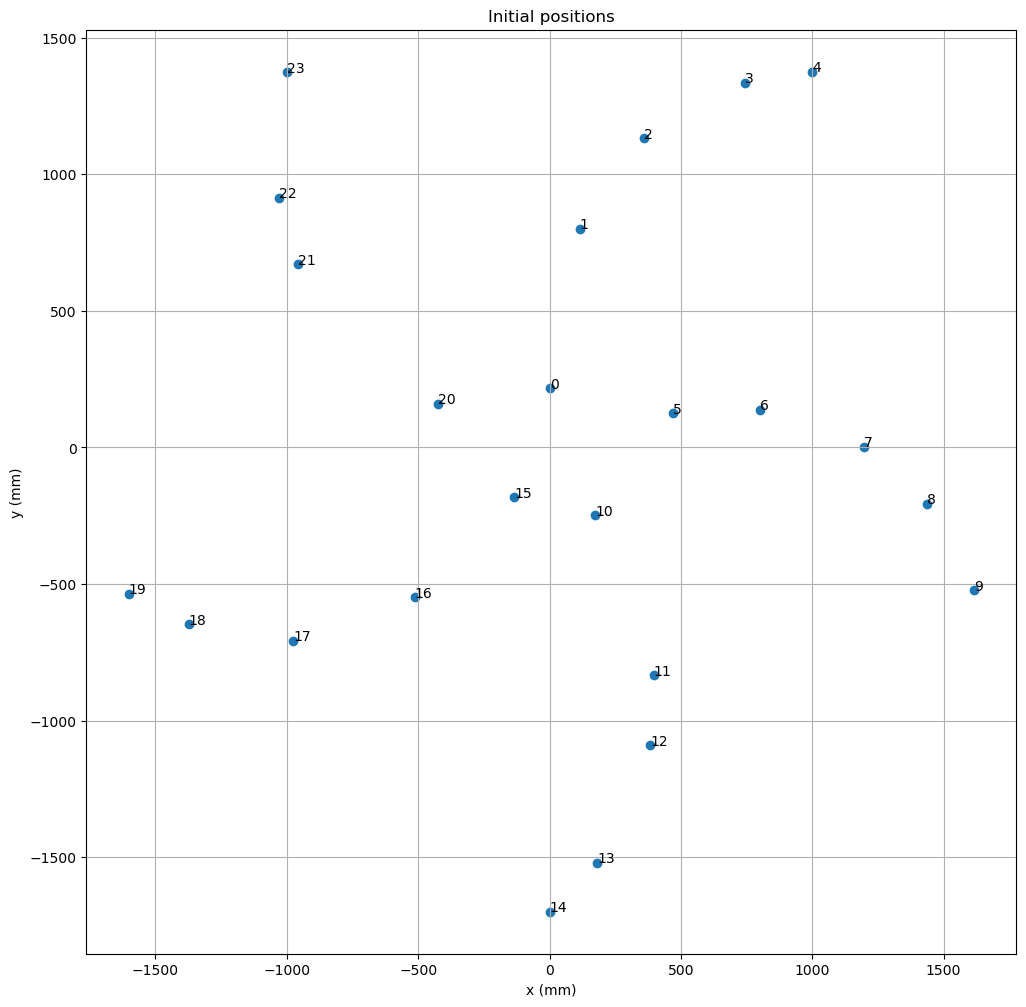

In [7]:
def i_y(i):
    return 2*i+1

def i_x(i):
    return 2*i


initial_guess = np.zeros(2*n_ant)

for i in range(n_ant):
    x,y = current_pos[i][0:2]*1000
    initial_guess[i_x(i)] = x
    initial_guess[i_y(i)] = y
    
    print(x,y)
initial_guess

pos_i = current_pos*1000
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(pos_i[:,0], pos_i[:,1])
for i in range(0,pos_i.shape[0]):
    ax.text(pos_i[i,0], pos_i[i,1],f"{i}")

ax.grid(True)
ax.set_title('Initial positions')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
plt.savefig('initial_positions.png')
plt.show()

## Criteria for Optimality

The function below is minimized when the positions (in variable x) are consistent with the measured distances m[i,j]. The initial value of this function is more than 3 million.

Note that the x input is a 1D vector of with 48 entries as [p0.x, p0.y, p1.x, p1.y]

In [ ]:
def geo_angle(x,y):
    return 90 - np.degrees(np.arctan2(y,x))

geo_angle(1,0)

In [8]:
def dist(a,b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)


def p(x, i):
    return [x[i_x(i)],x[i_y(i)]]

max_err = 4200
def bounds():
    ret = [(0,0)]*48
    for i in range(n_ant):
        _x,_y = pos_i[i,0], pos_i[i,1]
        ret[i_x(i)] = (_x - max_err, _x + max_err)
        ret[i_y(i)] = (_y - max_err, _y + max_err)
    
    return ret

bnd = bounds()

center = [0,0]

def angle(x, i):
    _x, _y = p(x, i)
    return geo_angle(_x, _y)
    
def radius_model(x):
    ret = []
    
    for i in range(n_ant):
        p_i = p(x,i)
        ret.append(dist(center, p_i))
        
    return np.array(ret)

non_nan_ij = []
non_nan_indices = []
for i in range(n_ant):
    for j in range(n_ant):
        if not np.isnan(m_ij[i,j]):
            non_nan_ij.append(m_ij[i,j])
            non_nan_indices.append([i,j])
non_nan_ij = np.array(non_nan_ij)
non_nan_indices = np.array(non_nan_indices)

def m_ij_model(x):
    ret = []
    for i in range(n_ant):
        p_i = p(x,i)

        for j in range(n_ant):
            p_j = p(x,j)
            if not np.isnan(m_ij[i,j]):
                ret.append(dist(p_j, p_i))
                
    return np.array(ret)
    
def radius_residual(x):
    predict = radius_model(x)
    return predict - radius

def m_ij_residual(x):
    predict = m_ij_model(x)
    return predict - non_nan_ij

def rot_residual(x):
    predict = angle(x, global_rot_index)
    return predict - global_rot_degrees

def f_old(x):
    ret = 0
    for i in range(n_ant):
        p_i = p(x,i)
        ret += (dist(center, p_i) - m_0[i])**2
        for j in range(n_ant):
            p_j = p(x,j)
            if not np.isnan(m_ij[i,j]):
                ret += (dist(p_j, p_i) - m_ij[i,j])**2
    return ret

def f(x):
    # This is the final criterion for optimality. The sum of squared residuals.
    ret = np.sum(radius_residual(x)**2)
    ret += np.sum(m_ij_residual(x)**2)
    ret += rot_residual(x)**2
    return ret


In [9]:
geo_angle(-1,0)

np.float64(-90.0)

In [10]:
print(f(initial_guess))

40125.06672592051


We can see that the initial value of this optimality condition is about seven million.

In [11]:
res = minimize(f, initial_guess, bounds=None, options={'maxiter': 1000})
res

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 18541.24322304791
        x: [-2.019e+02 -8.714e+01 ... -8.839e+02 -1.458e+03]
      nit: 378
      jac: [ 1.221e-03 -4.883e-04 ... -6.104e-03 -1.270e-02]
 hess_inv: [[ 5.248e-02 -2.848e-02 ...  1.110e-01 -6.388e-02]
            [-2.848e-02  1.170e-01 ... -3.809e-01  2.748e-01]
            ...
            [ 1.110e-01 -3.809e-01 ...  1.749e+00 -1.186e+00]
            [-6.388e-02  2.748e-01 ... -1.186e+00  8.467e-01]]
     nfev: 24414
     njev: 498

In [12]:
err = res.jac.reshape((24,2))
rms = err # np.sqrt(np.sum(err**2, axis=1))
for i in range(24):
    print(f"Ant {i}:\tJac: {rms[i,0]:06.2f}, \t{rms[i,1]:06.2f}")

Ant 0:	Jac: 000.00, 	-00.00
Ant 1:	Jac: -00.01, 	-00.01
Ant 2:	Jac: 000.00, 	000.01
Ant 3:	Jac: 000.00, 	-00.00
Ant 4:	Jac: -00.00, 	000.01
Ant 5:	Jac: 000.01, 	-00.01
Ant 6:	Jac: 000.00, 	000.01
Ant 7:	Jac: 000.00, 	000.01
Ant 8:	Jac: -00.00, 	000.01
Ant 9:	Jac: -00.01, 	000.01
Ant 10:	Jac: 000.01, 	-00.01
Ant 11:	Jac: 000.01, 	-00.00
Ant 12:	Jac: -00.00, 	000.00
Ant 13:	Jac: 000.01, 	-00.01
Ant 14:	Jac: 000.00, 	000.00
Ant 15:	Jac: 000.01, 	000.00
Ant 16:	Jac: 000.00, 	-00.00
Ant 17:	Jac: 000.00, 	-00.01
Ant 18:	Jac: -00.01, 	000.01
Ant 19:	Jac: 000.02, 	000.01
Ant 20:	Jac: 000.00, 	-00.01
Ant 21:	Jac: -00.01, 	-00.01
Ant 22:	Jac: -00.00, 	000.00
Ant 23:	Jac: -00.01, 	-00.01


The optimized positions are now known. The final value of the function is 32. Far closer to zero than 3 million!

We can recover the x,y coordinates by reshaping the array

In [13]:
pos = res.x.reshape((24,2))
pos

array([[ -201.90633896,   -87.13686606],
       [ -790.35125939,  -212.85385794],
       [-1188.21242814,  -108.31614423],
       [-1523.29487061,   162.64748048],
       [-1654.54104543,   383.54270623],
       [ -298.39036109,   378.97257551],
       [ -440.02545065,   679.98669244],
       [ -473.61727726,  1095.31161052],
       [ -368.97659103,  1397.19094157],
       [ -142.92267244,  1686.64374386],
       [  158.35041996,   252.88306259],
       [  616.19633842,   683.72069216],
       [  857.11208764,   770.15872216],
       [ 1333.72230422,   751.55734055],
       [ 1564.69040374,   651.90363193],
       [  224.8437581 ,   -57.39479079],
       [  708.86677689,  -267.12137362],
       [ 1026.99604296,  -634.91015051],
       [ 1130.35676521, -1022.13290058],
       [ 1106.28989654, -1283.12287402],
       [   18.10694455,  -462.98451711],
       [ -248.61799367, -1148.94718792],
       [ -448.48019699, -1308.39906466],
       [ -883.90264101, -1457.89388947]])

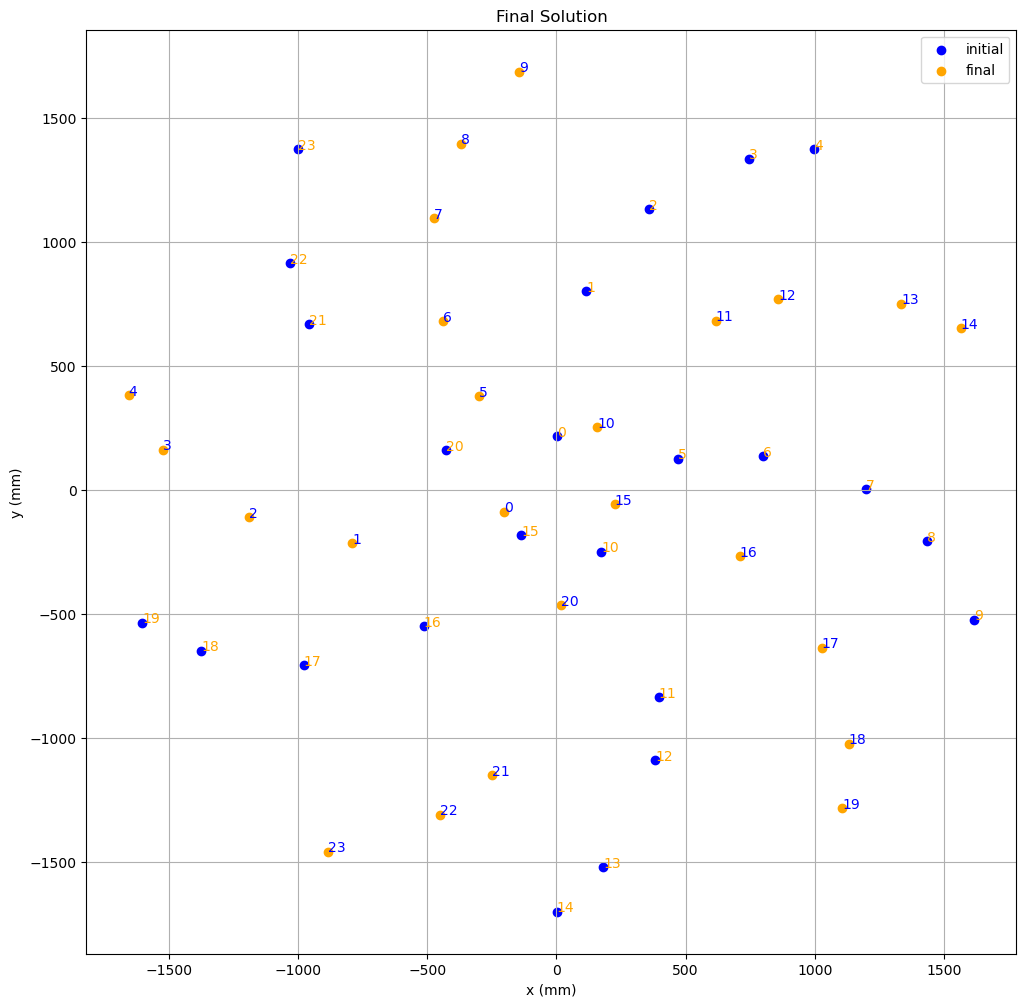

In [14]:
fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(pos_i[:,0], pos_i[:,1], label='initial', color='blue')
ax.scatter(pos[:,0], pos[:,1], label='final', color='orange')

for i in range(0,pos_i.shape[0]):
    ax.text(pos_i[i,0], pos_i[i,1],f"{i}", color='orange')

for i in range(0,pos.shape[0]):
    ax.text(pos[i,0], pos[i,1],f"{i}", color='blue')

ax.grid(True)
ax.set_title('Final Solution')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.legend()
plt.savefig('final_positions.png')
plt.show()

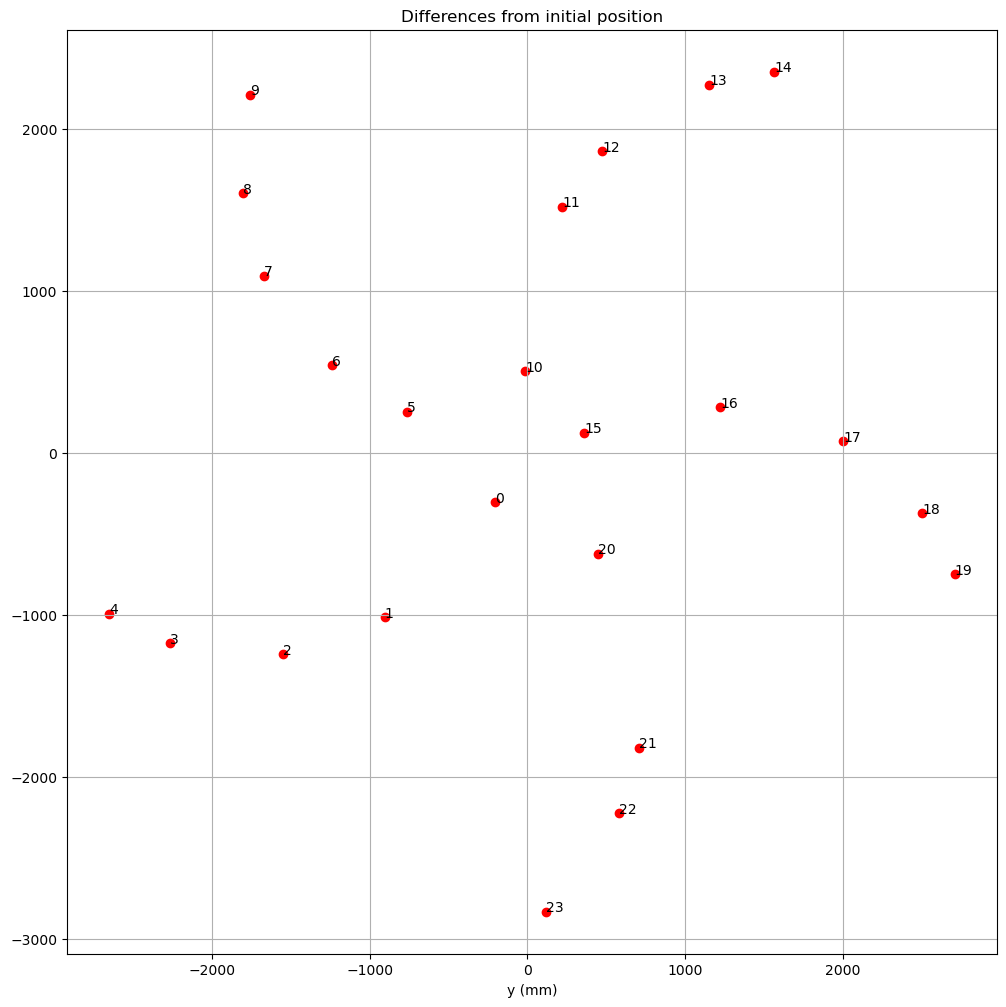

In [15]:
# Differences plot
diff = pos - pos_i[:,0:2]


fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(diff[:,0], diff[:,1], color='red')

for i in range(0,diff.shape[0]):
    ax.text(diff[i,0], diff[i,1],f"{i}")

ax.grid(True)
ax.set_title("Differences from initial position")
ax.set_xlabel('x (mm)')
ax.set_xlabel('y (mm)')
plt.savefig('differences.png')
plt.show()

In [16]:
# Residual plot
rres = radius_residual(res.x)
rres

A 0     -0.093194
A 1     -1.488010
A 2      3.139205
A 3      4.953480
A 4     -1.585716
A 5      7.345333
A 6      5.940923
A 7      8.323447
A 8      1.090396
A 9     -2.311603
A 10    -1.629930
A 11     2.419422
A 12    -0.704210
A 13     0.899612
A 14     0.061770
A 15     2.053609
A 16     2.526195
A 17    -0.592955
A 18     6.962625
A 19    11.190557
A 20     0.338456
A 21     2.538407
A 22    -0.872168
A 23     1.915972
Name: 0, dtype: float64

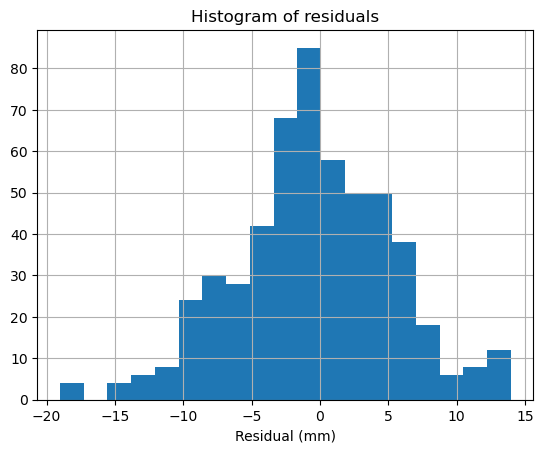

In [17]:
# ij resdual
ijres = m_ij_residual(res.x)
plt.hist(ijres, bins='fd');
plt.title("Histogram of residuals")
plt.xlabel("Residual (mm)")
plt.grid(True)
plt.savefig("residual_histogram.png")

The API expects 3D coordinates (with a z value which is zero in this case). Therefore we add a column of zeros.

In [18]:
absres = np.abs(ijres)
p95 = np.percentile(absres, 90)

print(f"95th percentile of residuals is {p95:4.2f} mm")
ijres_matrix = np.zeros_like(m_ij)
for r, i, j in zip(ijres, non_nan_indices[:,0], non_nan_indices[:,1]):
    if np.abs(r) > p95 and i > j:
        print(f" res[{i},{j}] = {r:3.1f}")
    ijres_matrix[i,j] = r
    


95th percentile of residuals is 9.83 mm
 res[3,0] = -11.2
 res[4,0] = -19.0
 res[5,1] = -13.4
 res[6,1] = -11.9
 res[6,2] = 11.8
 res[9,5] = 9.9
 res[10,5] = -11.2
 res[10,6] = -9.8
 res[11,5] = -10.0
 res[11,9] = -14.2
 res[14,0] = 10.0
 res[14,2] = -10.1
 res[14,4] = 12.4
 res[14,5] = 11.0
 res[14,11] = -14.0
 res[15,1] = 13.0
 res[15,2] = 14.0
 res[15,6] = -12.1
 res[16,0] = -13.6
 res[17,0] = -17.5
 res[18,7] = 12.4
 res[18,8] = 11.2
 res[20,17] = 13.4
 res[21,0] = 12.8
 res[22,18] = -10.4
 res[23,9] = 10.7
 res[23,20] = 9.9


## Output best estimates

Write some json files...

In [19]:
result = np.zeros((n_ant, 3))
result[:,:-1] = np.round(pos/1000.0, 3)
result

array([[-0.202, -0.087,  0.   ],
       [-0.79 , -0.213,  0.   ],
       [-1.188, -0.108,  0.   ],
       [-1.523,  0.163,  0.   ],
       [-1.655,  0.384,  0.   ],
       [-0.298,  0.379,  0.   ],
       [-0.44 ,  0.68 ,  0.   ],
       [-0.474,  1.095,  0.   ],
       [-0.369,  1.397,  0.   ],
       [-0.143,  1.687,  0.   ],
       [ 0.158,  0.253,  0.   ],
       [ 0.616,  0.684,  0.   ],
       [ 0.857,  0.77 ,  0.   ],
       [ 1.334,  0.752,  0.   ],
       [ 1.565,  0.652,  0.   ],
       [ 0.225, -0.057,  0.   ],
       [ 0.709, -0.267,  0.   ],
       [ 1.027, -0.635,  0.   ],
       [ 1.13 , -1.022,  0.   ],
       [ 1.106, -1.283,  0.   ],
       [ 0.018, -0.463,  0.   ],
       [-0.249, -1.149,  0.   ],
       [-0.448, -1.308,  0.   ],
       [-0.884, -1.458,  0.   ]])

In [20]:
json_result = {}
json_result["antenna_positions"] = result.tolist()

f = open("kenya_processed_antenna_positions.json", "w")
f.write(json.dumps(json_result))
f.close()

pos_json = json.dumps(json_result, indent=4, separators=(',', ': '))
print(pos_json)

{
    "antenna_positions": [
        [
            -0.202,
            -0.087,
            0.0
        ],
        [
            -0.79,
            -0.213,
            0.0
        ],
        [
            -1.188,
            -0.108,
            0.0
        ],
        [
            -1.523,
            0.163,
            0.0
        ],
        [
            -1.655,
            0.384,
            0.0
        ],
        [
            -0.298,
            0.379,
            0.0
        ],
        [
            -0.44,
            0.68,
            0.0
        ],
        [
            -0.474,
            1.095,
            0.0
        ],
        [
            -0.369,
            1.397,
            0.0
        ],
        [
            -0.143,
            1.687,
            0.0
        ],
        [
            0.158,
            0.253,
            0.0
        ],
        [
            0.616,
            0.684,
            0.0
        ],
        [
            0.857,
            0.77,
            0.

The position file above is in a format suitable for uploading to the telescope api. Also for using as the calibrated_antenna_positions.json file in TART/software/containers/telescope_web_api/config_data.


    tart_upload_antenna_positions --api https://tart.elec.ac.nz/rhodes --pw=xxxx --file biust_antenna_positions.json
